# Студент: Спиридонов Кирилл Анатольевич
# Группа: М8О-207М-19

# Домашняя работа №4

In [1]:
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
from skimage.feature import hog
from skimage import exposure

# Задача №1 - Хвост кита

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображении, нормировался, отображался на черный фон и подавался нейронной сети на вход.

Ваша задача - написать программу, которая совершит предобработку картинки, описанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер и равномерно занимало место, то есть, если хвост был повернут, его нужно выпрямить.

Изображения хвостов находятся в папке whale_tail/images к этому занятию. Разметка картинок (маски хвостов) лежат в папке whale_tail/ground_truth. После выделения хвоста посчитайте IoU для каждой картинки (ипсользуя маски из whale_tail/ground_truth)

<table><tr>
    <td> <img src="whale_tail/images/test_image_01.jpg" alt="Drawing" style="width: 400px;"/>
    <td> <img src="whale_tail/ground_truth/test_image_01.png" alt="Drawing" style="width: 400px;"/> </td>
  
</tr></table>

In [2]:
!unzip hog.zip
!unzip whale_tail.zip

Archive:  hog.zip
   creating: hog/
  inflating: hog/eye.png             
  inflating: hog/eyes.jpg            
  inflating: hog/eyes_dark.jpg       
  inflating: hog/woman.jpg           
Archive:  whale_tail.zip
   creating: whale_tail/
   creating: whale_tail/ground_truth/
  inflating: whale_tail/ground_truth/labelmap.txt  
  inflating: whale_tail/ground_truth/test_image_00.png  
  inflating: whale_tail/ground_truth/test_image_01.png  
  inflating: whale_tail/ground_truth/test_image_02.png  
  inflating: whale_tail/ground_truth/test_image_03.png  
  inflating: whale_tail/ground_truth/test_image_08.png  
  inflating: whale_tail/ground_truth/test_image_10.png  
   creating: whale_tail/images/
  inflating: whale_tail/images/test_image_00.jpg  
  inflating: whale_tail/images/test_image_01.jpg  
  inflating: whale_tail/images/test_image_02.jpg  
  inflating: whale_tail/images/test_image_03.jpg  
  inflating: whale_tail/images/test_image_08.jpg  
  inflating: whale_tail/images/test_image_1

# IoU
 Intercetion over union - число от 0 до 1, показывающее, насколько у двух объектов (эталонного (ground true) и текущего) совпадает внутренний “объем”.

<table><tr>
    <td> <img src="../img/iou.png" alt="Drawing" style="width: 400px;"/>
  
</tr></table>

In [7]:
def ion2e(s):
    if s[-3:]=='jpg':
        return s[:-3]+'png'


# Функция для загрузки изображений и масок с их масштабированием
def process_img_and_mask(images_dir, masks_dir, target_size=(256, 256)):
    images = {}
    masks = {}
    for filename in os.listdir(images_dir):
        if filename.endswith(".jpg"):
            new_filename = ion2e(filename)
            img_path = os.path.join(images_dir, filename)
            mask_path = os.path.join(masks_dir, new_filename)
            if os.path.exists(mask_path):
                img = cv2.imread(img_path)
                img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)

                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

                images[filename] = img_resized
                masks[filename] = mask_resized
    return images, masks

In [8]:
images_dir = './whale_tail/images/'
masks_dir = './whale_tail/ground_truth/'
images, masks = process_img_and_mask(images_dir, masks_dir, target_size=(256, 256))
print(f"Загружено изображений: {len(images)}")
print(f"Загружено масок: {len(masks)}")


Загружено изображений: 6
Загружено масок: 6


In [9]:
# Функция для обработки изображения
def process_image(image, mask, target_size=(256, 256)):
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None

    largest_contour = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    box = np.intc(box)

    width, height = target_size
    src_pts = np.array(box, dtype="float32")
    dst_pts = np.array([[0, height], [0, 0], [width, 0], [width, height]], dtype="float32")
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    aligned_tail = cv2.warpPerspective(masked_image, M, target_size)

    predicted_mask = cv2.warpPerspective(mask, M, target_size)
    return aligned_tail, predicted_mask

In [10]:
# Функция для вычисления метрики IoU
def find_iou(predicted_mask, ground_truth_mask):
    intersection = np.logical_and(predicted_mask, ground_truth_mask).sum()
    union = np.logical_or(predicted_mask, ground_truth_mask).sum()
    return intersection / union if union != 0 else 0

In [11]:
# Обработка всех изображений и вычисление IoU
def process_and_evaluate(images, masks, target_size=(256, 256)):
    iou_scores = {}
    for filename, image in images.items():
        mask = masks.get(filename)
        if mask is None:
            continue

        processed_image, predicted_mask = process_image(image, mask, target_size)
        if processed_image is None or predicted_mask is None:
            iou_scores[filename] = None
            continue

        # Преобразование масок для IoU
        predicted_mask_binary = predicted_mask > 0
        ground_truth_binary = mask > 0

        # Вычисление IoU
        iou_scores[filename] = find_iou(predicted_mask_binary, ground_truth_binary)

    return iou_scores


In [12]:
target_size = (256, 256)

iou_scores = process_and_evaluate(images, masks, target_size)
for filename, iou in iou_scores.items():
    print(f"{filename}: IoU = {iou:.4f}")

test_image_10.jpg: IoU = 0.6326
test_image_08.jpg: IoU = 0.1374
test_image_00.jpg: IoU = 0.3692
test_image_02.jpg: IoU = 0.3931
test_image_01.jpg: IoU = 0.4497
test_image_03.jpg: IoU = 0.1964


In [14]:
def display_results(images, processed_images, predicted_masks, num_images=5):
    filenames = list(images.keys())
    num_images = min(num_images, len(filenames))

    for i in range(num_images):
        filename = filenames[i]
        original = images[filename]
        processed = processed_images.get(filename)
        predicted_mask = predicted_masks.get(filename)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title("Оригинальное изображение")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        if processed is not None:
            plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
            plt.title("Обработанное изображение")

        plt.subplot(1, 3, 3)
        if predicted_mask is not None:
            plt.imshow(predicted_mask, cmap="gray")
            plt.title("Предсказанная маска")

        plt.show()

In [15]:
def process_and_save_with_display(images, masks, target_size=(256, 256)):
    iou_scores = {}
    processed_images = {}
    predicted_masks = {}

    for filename, image in images.items():
        mask = masks.get(filename)
        if mask is None:
            continue

        processed_image, predicted_mask = process_image(image, mask, target_size)
        if processed_image is None or predicted_mask is None:
            iou_scores[filename] = None
            continue

        predicted_mask_binary = predicted_mask > 0
        ground_truth_binary = mask > 0
        iou_scores[filename] = find_iou(predicted_mask_binary, ground_truth_binary)

        processed_images[filename] = processed_image
        predicted_masks[filename] = predicted_mask

    return iou_scores, processed_images, predicted_masks

test_image_10.jpg: IoU = 0.6326
test_image_08.jpg: IoU = 0.1374
test_image_00.jpg: IoU = 0.3692
test_image_02.jpg: IoU = 0.3931
test_image_01.jpg: IoU = 0.4497
test_image_03.jpg: IoU = 0.1964


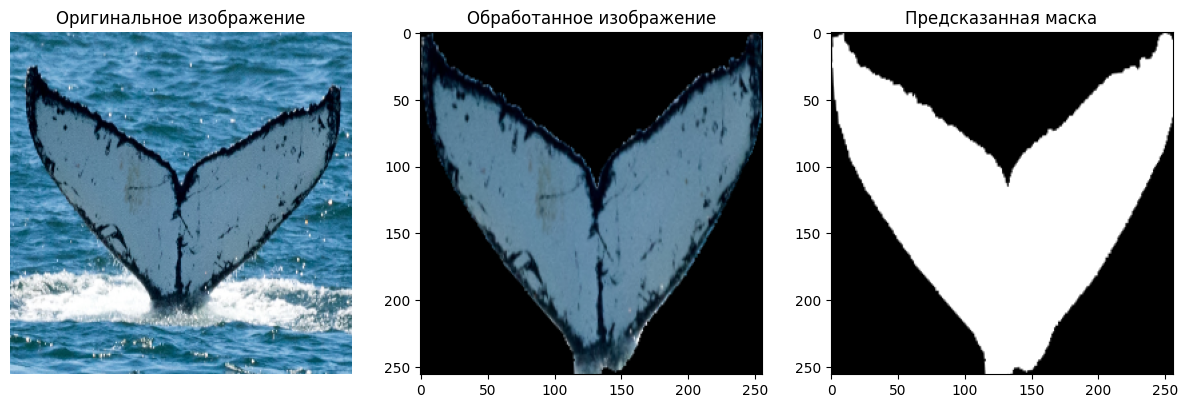

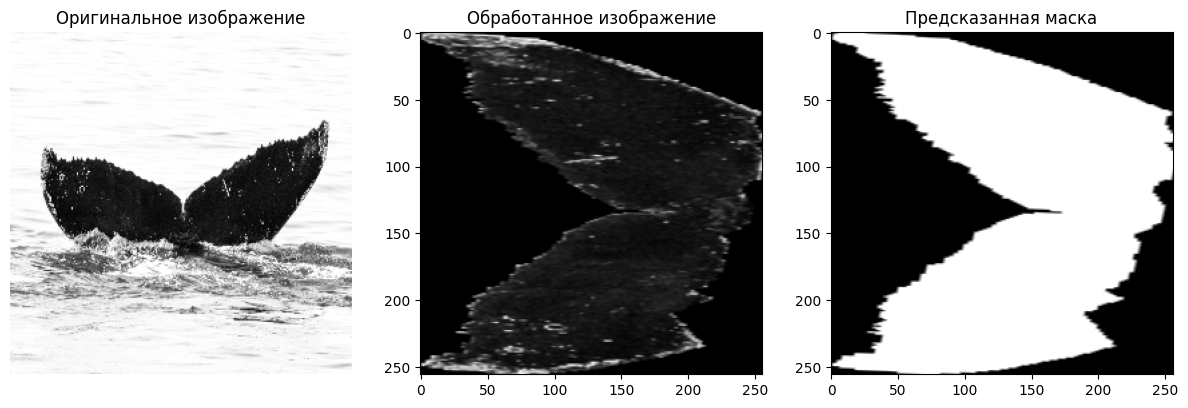

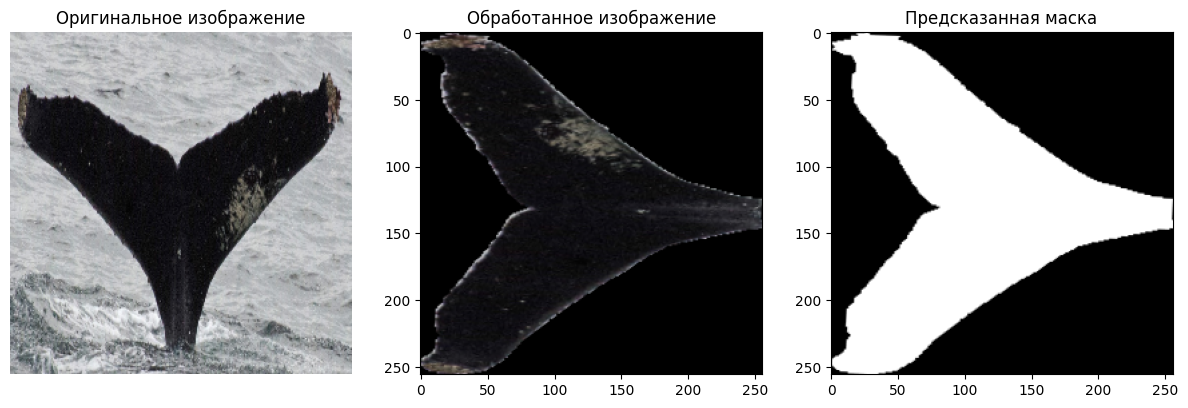

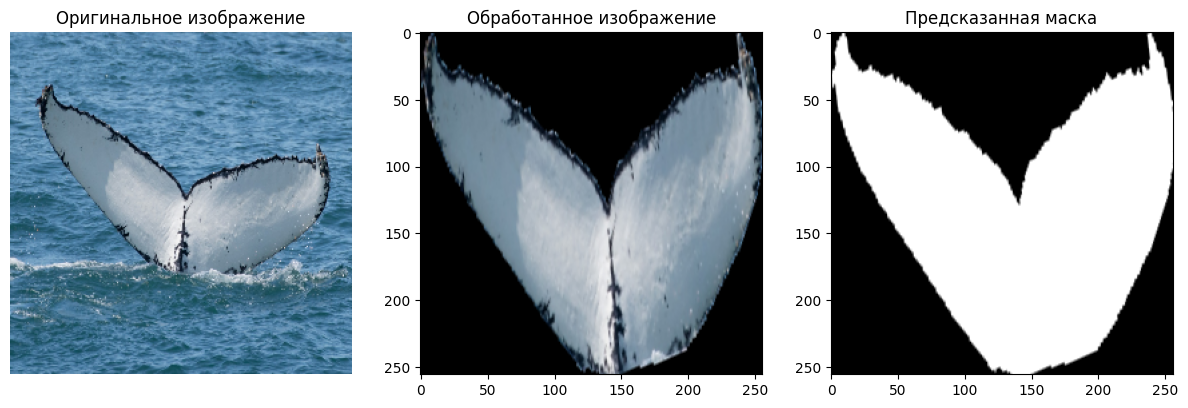

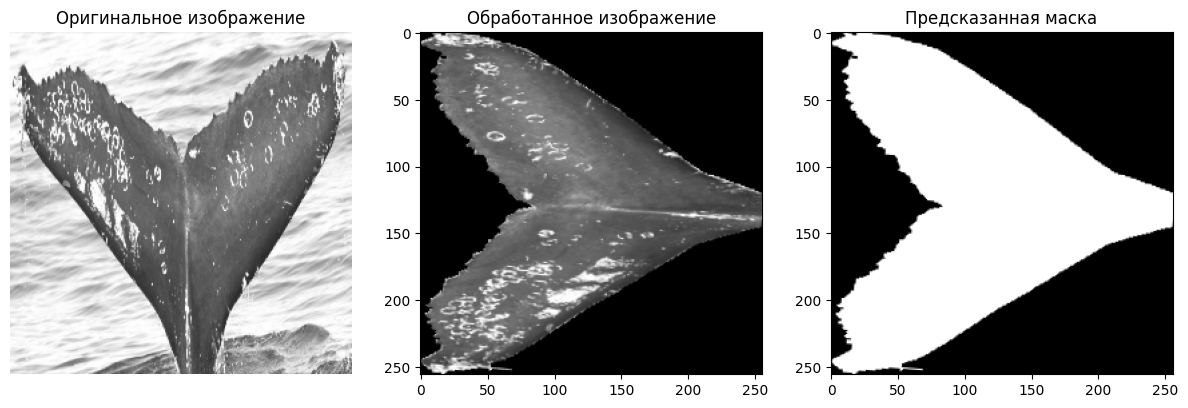

In [16]:
iou_scores, processed_images, predicted_masks = process_and_save_with_display(images, masks, target_size)
for filename, iou in iou_scores.items():
    print(f"{filename}: IoU = {iou:.4f}")

display_results(images, processed_images, predicted_masks, num_images=5)

# Задача №2 - Найти шаблон на изображении с помощью HOG и кросс-корреляции

Ваша задача - написать программу, которая сможет найти шаблон одного глаза на нескольких изображениях, в том числе затемненных. Использовать нужно HOG представление изображений, поиск шаблона сделать с помощью кросс-корреляции

Изображение глаз человека и шаблон, который нужно на нем найти, находятся в папке hog

<table><tr>
    <td> <img src="hog/eye.png" alt="Drawing" style="width: 400px;"/>
</tr></table>     /

<table><tr>
    <td> <img src="hog/eyes.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/eyes_dark.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/woman.jpg" alt="Drawing" style="width: 200px;"/> </td>

</tr></table>

In [17]:
template_path = "./hog/eye.png"
template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)

template_shape = template.shape

In [18]:
def preprocess_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    gray_image = cv2.equalizeHist(gray_image)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    return blurred_image

In [19]:
def compute_hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    fd, hog_image = hog(
        image, orientations=orientations, pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block, visualize=True
    )
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return fd, hog_image_rescaled


In [20]:
def find_eye_with_correlation(image, template, template_hog, template_shape):
    preprocessed_image = preprocess_image(image)

    result = cv2.matchTemplate(preprocessed_image, template, cv2.TM_CCOEFF_NORMED)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    window = preprocessed_image[max_loc[1]:max_loc[1]+template_shape[0], max_loc[0]:max_loc[0]+template_shape[1]]
    if window.shape == template_shape:
        window_hog, _ = compute_hog(window)
        score = np.sum(window_hog - template_hog)
    else:
        score = -1

    return max_loc, max_val, score

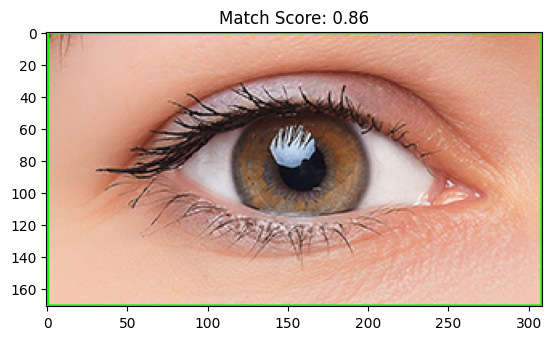

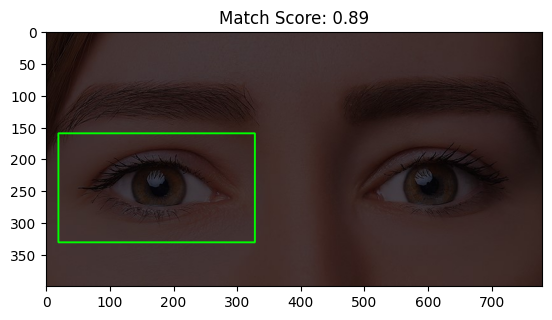

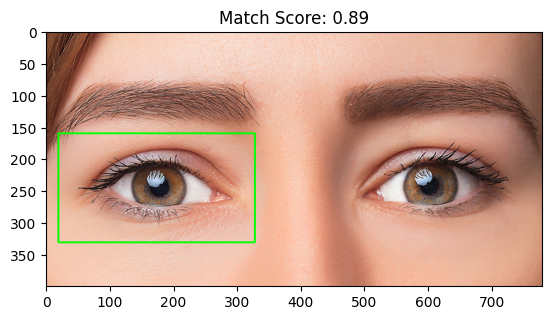

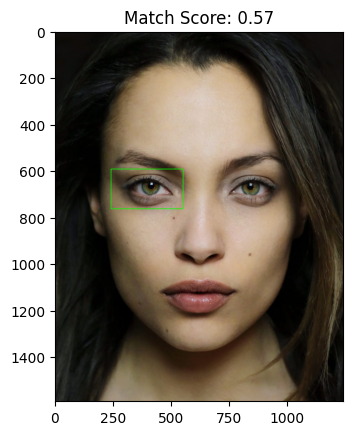

In [21]:
images = ["./hog/eye.png", "./hog/eyes_dark.jpg", "./hog/eyes.jpg", "./hog/woman.jpg"]

for image_path in images:
    image = cv2.imread(image_path)

    template_hog, _ = compute_hog(template)
    position, score, template_score = find_eye_with_correlation(image, template, template_hog, template_shape)

    if position:
        x, y = position
        h, w = template_shape
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Match Score: {score:.2f}")
    plt.show()
